In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

from src.CPQAOA import CP_QAOA
from src.Qsim_CPQAOA import Qsim_CPQAOA
from src.Qulacs_CPQAOA import Qulacs_CPQAOA

from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       qubo_limits, 
                       check_qubo)

In [2]:
N_min, N_max = 4, 18

qiskit_res = {N: [] for N in range(N_min, N_max + 1)}
qsim_res =   {N: [] for N in range(N_min, N_max + 1)}
qulacs_res = {N: [] for N in range(N_min, N_max + 1)}

N_seeds = 5
seed = 100
w_nnn = False

layer_dict = {4:  1, 5:  1, 6 : 1,
              7:  2, 8 : 2, 9 : 2, 
              10: 3, 11: 3, 12: 3, 
              13: 4, 14: 4, 15: 4, 
              16: 5, 17: 5, 18: 5, 
              19: 6, 20: 6, 21: 6}

 # Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[0]
for N in tqdm(range(N_min, N_max+1)):
    k = N // 2
    init_strat = np.array([1 if i%2 == 1 else 0 for i in range(N)])
    my_indices = [(i, i+1) for i in range(N-1)]
    alpha = 0.5
    max_iter = 10
    for repetition in range(N_seeds):
         # Defining topology
        my_chain = Chain(N_qubits=N)
        my_chain.set_initialization_strategy(strategy=init_strat)
        # Deciding between grid and 1d chain topology
        my_topology = my_chain
        # Generating random problem instance 
        expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
        # Retrieving C_min, C_max and corresponding states for original portfolio problem
        constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                    k=k,
                                                                    mu=expected_returns,
                                                                    sigma=covariances,
                                                                    alpha=alpha)
        portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
        portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
        # Generating QUBO corresponding to current problem instance
        Q, offset = get_qubo(mu=expected_returns,
                             sigma=covariances, 
                             alpha=alpha,
                             lmbda=lmbda+1e-8, # Adding small constant purposely
                             k=k)
        QUBO_limits = qubo_limits(Q=Q,offset=offset)
        qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
        qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
        check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
        qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
        
        if not portfolio_subspace_min_state_str == qubo_min_state_str:
            raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
        
        if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
            raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
        
        if not qubo_max_cost >= portfolio_subspace_max_cost:
            raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')
         
        qiskit_ansatz = CP_QAOA(N_qubits=N,
                                cardinality=k,
                                layers=layer_dict[N],
                                topology=my_topology,
                                with_next_nearest_neighbors=w_nnn,
                                QUBO_matrix=Q)

        qsim_ansatz = Qsim_CPQAOA(N_qubits=N,
                                  cardinality=k, 
                                  layers=layer_dict[N],
                                  topology=my_topology,
                                  QUBO_matrix=Q,
                                  with_next_nearest_neighbors=w_nnn,
                                  get_full_state_vector=False)
         
        qulacs_ansatz = Qulacs_CPQAOA(N_qubits=N,
                                      cardinality=k, 
                                      layers=layer_dict[N],
                                      topology=my_topology,
                                      with_next_nearest_neighbors=w_nnn,
                                      use_parametric_circuit_opt=True,
                                      get_full_state_vector=False,
                                      QUBO_matrix=Q)

        
        # Generating initial guess for rotation angles
        np.random.seed(seed)
        theta_min, theta_max = -2*np.pi, 2*np.pi
        N_angles = layer_dict[N] * len(my_topology.get_NNN_indices()) if w_nnn else layer_dict[N] * len(my_topology.get_NN_indices())
        theta_i = np.random.uniform(-2*np.pi, 2*np.pi, N_angles)
        
        qiskit_start_time = time()
        qiskit_sim = sc.optimize.minimize(fun=qiskit_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        qiskit_stop_time = time()
        if qiskit_sim['nfev'] > 0:
            time_pr_iter = (qiskit_stop_time-qiskit_start_time) / qiskit_sim['nfev']
            qiskit_res[N].append(time_pr_iter)
        

        qsim_start_time = time()
        qsim_sim = sc.optimize.minimize(fun=qsim_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        qsim_stop_time = time()
        if qsim_sim['nfev'] > 0:
            time_pr_iter = (qsim_stop_time-qsim_start_time) / qsim_sim['nfev']
            qsim_res[N].append(time_pr_iter)
             
        
        qulacs_start_time = time()
        qulacs_sim = sc.optimize.minimize(fun=qulacs_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        qulacs_stop_time = time()
        if qulacs_sim['nfev'] > 0:
            time_pr_iter = (qulacs_stop_time-qulacs_start_time) / qulacs_sim['nfev']
            qulacs_res[N].append(time_pr_iter)
             
            
        seed += 1

100%|██████████| 15/15 [05:03<00:00, 20.21s/it]


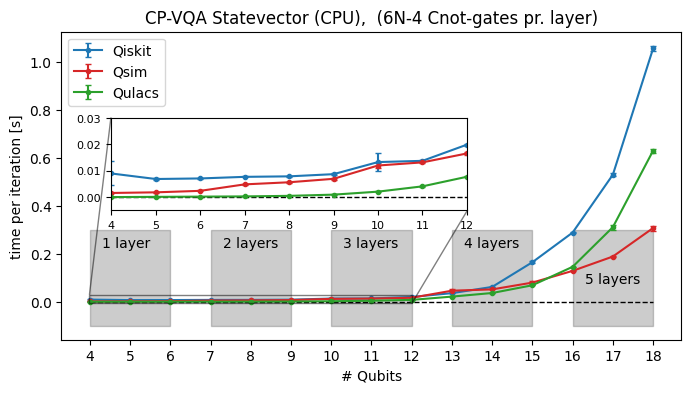

In [3]:
qiskit_avgs = np.array([[np.mean(qiskit_res[key]), np.std(qiskit_res[key])] for key in qiskit_res.keys()])
qsim_avgs = np.array([[np.mean(qsim_res[key]), np.std(qsim_res[key])] for key in qsim_res.keys()])
qulacs_avgs = np.array([[np.mean(qulacs_res[key]), np.std(qulacs_res[key])] for key in qulacs_res.keys()])

N_vals = [n for n in range(N_min, N_max+1)]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_title('CP-VQA Statevector (CPU),  (6N-4 Cnot-gates pr. layer)')

ax.errorbar(N_vals, qiskit_avgs[:,0], yerr=qiskit_avgs[:,1], fmt='.-', capsize=2, label='Qiskit', color='tab:blue')
ax.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='Qsim', color='tab:red')
ax.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:green')
ax.hlines(0, N_vals[0], N_vals[-1],ls='--',color='k', lw = 1)
ax.set_ylabel('time per iteration [s]')
ax.set_xlabel('# Qubits')
ax.set_xticks(N_vals)

ax.fill_between(np.linspace(4,6,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(4.3,0.225,'1 layer')

ax.fill_between(np.linspace(7,9,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(7.3,0.225,'2 layers')

ax.fill_between(np.linspace(10,12,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(10.3,0.225,'3 layers')

ax.fill_between(np.linspace(13,15,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(13.3,0.225,'4 layers')

ax.fill_between(np.linspace(16,18,100), -np.ones(100)*0.1, np.ones(100)*0.3, alpha=0.2, color='k')
ax.text(16.3,0.075,'5 layers')

"""ax.fill_between(np.linspace(19,21,100), -np.ones(100)*0.1, np.ones(100)*2.5, alpha=0.2, color='k')
ax.text(19.5,2,'6 layers')"""

################## miniplot ##################
# inset axes....
axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.08, 0.42, 0.575, 0.3
axins = ax.inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])
axins.errorbar(N_vals, qiskit_avgs[:,0], yerr=qiskit_avgs[:,1], fmt='.-', capsize=2, label='Qiskit', color='tab:blue')
axins.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='Qsim', color='tab:red')
axins.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:green')
axins.hlines(0, N_vals[0], N_vals[-1],ls='--',color='k', lw = 1)

axins.set_xticks([4,5,6,7,8,9,10,11,12])
#axins.set_yticks([])
# sub region of the original image
x1, x2, y1, y2 = 3.99, 12.01, -0.005, 0.03
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis='both', which='major', labelsize=8)
ax.indicate_inset_zoom(axins, edgecolor="black")



ax.legend()
#plt.savefig('simulator_comparison_3.png', dpi=400)